# Basic VAE implementation

This notebook defines a basic VAE to model the MNIST dataset, using PyTorch.

## VAE Theory

The goal of a VAE is to (implicitly) learn a distribution $p(x),\,x \in X$, with $X$ a vector space, which is as similar as possible to an unknown target distribution $p^{*}(x)$, given a set of samples from this distribution $\mathcal{D}=\{x_1, ..., x_{n}\}$. VAEs make the assumption that $x$ depends on some set of underlying latent variables $z \in Z$, which are distributed according to some known distribution $p(z)$, and model the likelihood $p(x\mid z)$ and an approximation of the posterior distribution $p(z \mid x)$.

To help them learn, VAEs use variational inference. In this approach, instead of computing the posterior $p(z \mid x)$, which is often intractable, one searches for a more tractable distribution $q(z \mid x)$ which approximates the posterior. VAEs assume parameterised models of the likelihood and the approximate posterior, given by $p(x \mid z,\theta)$ and $q(z \mid x, \theta)$, where $\theta$ represent model parameters. To learn  $q(z \mid x, \theta)$, we maximise the Evidence Lower Bound (or ELBO) over the training data, which is given by

\begin{equation}
ELBO = \sum_{i=1}^{n} \mathbb{E}_{q(z_{i} \mid x_{i},\theta)} \left[\log p(x_{i} \mid z_{i},\theta) \right] - D_{\mathrm{KL}}(q(z_{i}\mid x_{i},\theta) \, \| \, p(z_{i}))~,
\end{equation}
assuming the training samples are independently and identically distributed. 

To be able to compute the ELBO, we assume a Gaussian VAE:
\begin{align}
\label{eq:vae_likelihood}
p(x \mid z,\theta)&=\mathcal{N}(x; f(z; \theta_{f}), \sigma^{2} I)
\\
\label{eq:vae_prior}
p(z)&=\mathcal{N}(z; 0, I)
\\
\label{eq:vae_q}
q(z\mid x,\theta)&=\mathcal{N}(z; g(x;\theta_{g}), \mathrm{diag}(h(x;\theta_{h})^{2}))~,
\end{align}
where $f$, $g$ and $h$ are all deep neural networks parameterised by $\theta=\{\theta_{f},\theta_{g},\theta_{h}\}$, $\sigma$ is a hyperparameter. Our optimal network parameters are then given by

\begin{equation}
\label{eq:vae_mle}
\hat \theta_{f}, \hat \theta_{g}, \hat \theta_{h} = argmin_{\theta_{f}, \theta_{g}, \theta_{h}}  \left\{ \sum_{i=1}^{n} \mathbb{E}_{q(z_{i} \mid x_{i}, \theta_{g},\theta_{h})} \left[{\| x_{i}-f(z_{i};\theta_{f}) \|^{2} \over 2 \sigma^{2}}\right] + D_{\mathrm{KL}}(q(z_{i}\mid x_{i},\theta_{g},\theta_{h}) \, \| \, p(z_{i})) \right\}~.
\end{equation}

The KL term above can easily be computed analytically as it involves two normal distributions. When calculating the expectation over $q(z\mid x,\theta)$, which is usually carried out via sampling, a "reparameterisation trick" is used. One notes that sampling $z \sim q(z\mid x,\theta)$ is equivalent to sampling $\epsilon \sim \mathcal{N}(\epsilon;0,I)$ and computing $z=h(x;\theta_{h})\epsilon + g(x;\theta_{g})$, which allows gradient descent methods to be used to find $\hat \theta$.

> **Extension task**: show that the KL divergence term in this case can be analytically derived as: $D_{\mathrm{KL}}(q(z_{i}\mid x_{i},\theta_{g},\theta_{h}) \, \| \, p(z_{i}))= -{1\over 2} \sum^{J}_{j=1} \left[ 1 + \log(h_{j}^{2}) - h_{j}^{2} - g_{j}^{2} \right]$ where $J$ is the dimension of the latent vector.

For more on VAE theory, see: https://arxiv.org/abs/1606.05908 and https://arxiv.org/abs/1907.08956.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

## Load training data

First, we load the MNIST training data (similar to before), and plot some training examples.

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))

test_dataset = datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))

0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/home/jonas/anaconda3/envs/aml-practical/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


60000
10000


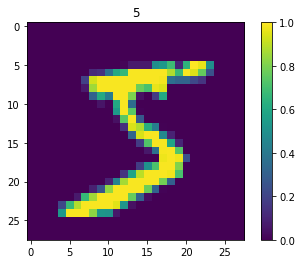

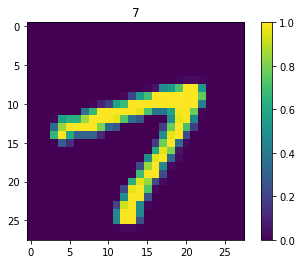

torch.Size([1, 28, 28])


In [4]:
print(len(train_dataset))
print(len(test_dataset))

for i in [0, 101]:
    im,label = train_dataset[i]
    
    plt.imshow(im.numpy()[0])
    plt.title(label)
    plt.colorbar()
    plt.show()

print(im.shape)

## Define network

Next we define the VAE.

> **Task 1**: comple the PyTorch VAE model below by implementing the `reparameterize` method which samples from the approximate posterior using the reparameterisation trick, and implementing the model's `forward` method, which returns the estimated parameters $f$,$g$ and $h$ of the likelihood and approximate posterior given a sample $x$.

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)# estimates mu, log-variance of approximate posterior q(z|x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
        # TODO: write some code which returns a random sample from the approximate posterior q(z|x) here
        


    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))# estimates mu of likelihood p(x|z)

    def forward(self, x):
        
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
        # TODO: write some code which returns
        # 1) mu,log-variance of the approximate posterior given x
        # 2) mu of the likelihood given a random sample from the posterior given x
        

        
        return recon, mu, logvar# should return  (likelihood mu, posterior mu, posterior log-variance)
    
model = VAE()

## Loss function

Next, we define the loss function to train the VAE model.

> **Task 2**: define a loss function to train the VAE model, which minimises the expression for the negative ELBO shown above.

In [19]:
def loss_function(recon, x, mu, logvar):
    
    BCE = F.binary_cross_entropy(recon, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD



## Train

Finally, we train the VAE model.

In [20]:
from torch import optim

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)# this automatically batches up examples, adding a batch dimension
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

> **Task 3**: write some code to train the VAE using the training data and the loss function defined above.

In [27]:
def train(epoch):
    model.train()
    
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        
        # TODO: write some code here
        # carry out an optimisation step for each batch
        # after each epoch report the average loss over the training dataset
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))



def test(epoch):
    model.eval()
    
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):

            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
for epoch in range(1, 5):
    train(epoch)
    test(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 109.120392
Train Epoch: 1 [6400/60000 (11%)]	Loss: 103.371941
Train Epoch: 1 [12800/60000 (21%)]	Loss: 102.188370
Train Epoch: 1 [19200/60000 (32%)]	Loss: 111.986038
Train Epoch: 1 [25600/60000 (43%)]	Loss: 109.921188
Train Epoch: 1 [32000/60000 (53%)]	Loss: 102.488220
Train Epoch: 1 [38400/60000 (64%)]	Loss: 107.942802
Train Epoch: 1 [44800/60000 (75%)]	Loss: 109.414200
Train Epoch: 1 [51200/60000 (85%)]	Loss: 106.431160
Train Epoch: 1 [57600/60000 (96%)]	Loss: 102.938583
====> Epoch: 1 Average loss: 108.0693
====> Test set loss: 106.8609
Train Epoch: 2 [0/60000 (0%)]	Loss: 106.235138
Train Epoch: 2 [6400/60000 (11%)]	Loss: 107.749176
Train Epoch: 2 [12800/60000 (21%)]	Loss: 105.837807
Train Epoch: 2 [19200/60000 (32%)]	Loss: 105.285507
Train Epoch: 2 [25600/60000 (43%)]	Loss: 108.019684
Train Epoch: 2 [32000/60000 (53%)]	Loss: 105.687309
Train Epoch: 2 [38400/60000 (64%)]	Loss: 104.912621
Train Epoch: 2 [44800/60000 (75%)]	Loss: 100.939232
Train Ep

## Evaluate

In this section we evaluate the performance of the trained VAE.

### Reconstruction quality

> **Task 4**: plot example VAE reconstructions (mean of the likelihood) for some of the images in the test set.

tensor([[[[1.4384e-07, 1.5234e-07, 1.0379e-07,  ..., 7.7273e-08,
           5.1871e-08, 1.1689e-07],
          [2.2406e-07, 5.3008e-08, 9.0643e-08,  ..., 1.2301e-07,
           1.2163e-07, 1.2209e-07],
          [2.5969e-07, 9.7767e-08, 7.0479e-08,  ..., 1.5486e-06,
           1.7523e-07, 4.9544e-08],
          ...,
          [7.2857e-08, 1.4418e-07, 6.8121e-07,  ..., 3.2214e-07,
           1.4336e-06, 9.1033e-08],
          [7.8043e-08, 3.5141e-08, 1.2250e-07,  ..., 1.2828e-06,
           1.5655e-07, 4.9021e-08],
          [5.4788e-08, 8.2004e-08, 1.1252e-07,  ..., 3.8187e-08,
           8.2464e-08, 7.0480e-08]]],


        [[[2.2193e-07, 1.7677e-07, 1.1069e-07,  ..., 2.5456e-07,
           5.2054e-08, 1.3452e-07],
          [1.8998e-07, 1.3311e-07, 8.0170e-08,  ..., 7.4151e-08,
           1.1974e-07, 1.0953e-07],
          [8.9656e-08, 5.1628e-08, 3.5492e-08,  ..., 6.1479e-09,
           1.1153e-07, 1.0476e-07],
          ...,
          [1.2208e-07, 7.6395e-08, 1.0688e-06,  ..., 3.12

TypeError: Invalid shape (64, 1, 28, 28) for image data

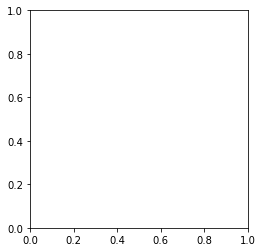

In [34]:
# TODO: write some code here
sample = torch.randn(64, 20)
sample = model.decode(sample).view(64,1,28,28)
print(sample)
plt.imshow(sample.detach().numpy()[0])
plt.colorbar()
plt.show()



### Latent space interpolation

Now that we have learnt a latent representation, we can interpolate smoothly between two digits by linearly interpolating between them in the latent space.

> **Task 5**: show the mean of the likelihood (image reconstruction) for a set latent vectors which are linearly interpolated between two test images in the latent space.

In [ ]:
# TODO: write some code here




### Random sampling of the posterior

We can also generate random samples of $x$ given values of $z$ drawn from its prior distribution (a unit Gaussian).

> **Task 6**: generate random latent vectors from the prior latent distribution and show the resulting likelihood means (image reconstructions).

In [ ]:
# TODO: write some code here




## Extensions

Have a go at these if you have time.

> What happens to the performance when you reduce the dimensionality of the latent space?

> Try using a Beta-VAE (https://openreview.net/forum?id=Sy2fzU9gl) : what happens when the KL term is made much stronger?

> Try using a binary cross-entropy loss instead of a L2 loss in the loss function (e.g. https://github.com/pytorch/examples/blob/master/vae/main.py)

> Try to run clustering in the latent space to label the test data.